In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import missingno as msno
import warnings
warnings.filterwarnings("ignore")
from matplotlib.gridspec import GridSpec 


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import AdaBoostClassifier

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler


In [4]:
dataframe = pd.read_csv(r'C:\Users\ADMIN\Downloads\dataset.csv')
dataframe=dataframe.drop('id', axis=1)
dataframe.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
def grab_columns(dataframe, categorial_th=10, car_th=20):


    categorial_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_categorial = [col for col in dataframe.columns if dataframe[col].nunique() < categorial_th and
                   dataframe[col].dtypes != "O"]
    categorial_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    categorial_cols = categorial_cols + num_but_categorial
    categorial_cols = [col for col in categorial_cols if col not in categorial_but_car]


    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_categorial]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'categorial_cols: {len(categorial_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'categorial_but_car: {len(categorial_but_car)}')
    print(f'num_but_categorial: {len(num_but_categorial)}')
    return categorial_cols, num_cols, categorial_but_car

In [6]:
def outlier_th(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    upper_bound = quartile3 + 1.5 * interquantile_range
    lower_bound = quartile1 - 1.5 * interquantile_range
    return lower_bound, upper_bound

def check_outlier(dataframe, col_name):
    lower_bound, upper_bound = outlier_th(dataframe, col_name)
    if dataframe[(dataframe[col_name] > upper_bound) | (dataframe[col_name] < lower_bound)].any(axis=None):
        return True
    else:
        return False  

def replace_with_thresholds(dataframe, variable):
    lower_bound, upper_bound = outlier_th(dataframe, variable)
    dataframe.loc[(dataframe[variable] < lower_bound), variable] = lower_bound
    dataframe.loc[(dataframe[variable] > upper_bound), variable] = upper_bound

In [7]:
def missing (dataframe):
    missing_number = dataframe.isnull().sum().sort_values(ascending=False)
    missing_percent = (dataframe.isnull().sum()/dataframe.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

missing(dataframe)

,Missing_Number,Missing_Percent
bmi,201,0.039335
gender,0,0.000000
age,0,0.000000
hypertension,0,0.000000
heart_disease,0,0.000000
ever_married,0,0.000000
work_type,0,0.000000
Residence_type,0,0.000000
avg_glucose_level,0,0.000000
smoking_status,0,0.000000


In [8]:
 num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

In [9]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='median')
dataframe['bmi'] = imp.fit_transform(dataframe['bmi'].to_numpy().reshape(-1, 1))
dataframe

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.1,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [10]:
categorial_cols, num_cols, categorial_but_car = grab_columns(dataframe)

Observations: 5110
Variables: 11
categorial_cols: 8
num_cols: 3
categorial_but_car: 0
num_but_categorial: 3


In [11]:
for col in num_cols:
    print(col, check_outlier(dataframe, col))

age False
avg_glucose_level False
bmi True


In [12]:
for col in num_cols:
    replace_with_thresholds(dataframe, col)
for col in num_cols:
    print(col, check_outlier(dataframe, col))

age False
avg_glucose_level False
bmi False


In [13]:
dataframe.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [14]:
#d_list = dataframe.select_dtypes(include = ['object']).columns.tolist()
#from sklearn.preprocessing import LabelEncoder

#le = LabelEncoder()

#for i in d_list:
 #   le.fit(dataframe[i])
  #  dataframe[i] = le.transform(dataframe[i])

In [15]:
dataframe.age[dataframe.age<=20] = 0
dataframe.age[(dataframe.age<=40) & (dataframe.age>20)] = 1
dataframe.age[(dataframe.age<=60) & (dataframe.age>40)] = 2
dataframe.age[dataframe.age>60] = 3

In [16]:
dataframe.smoking_status=[0 if item == "Unknown" else 1 if item=="never smoked" else 2 if item == "formerly smoked" else 3 for item in dataframe.smoking_status]

In [17]:
dataframe.Residence_type=[0 if item == "Urban" else 1 for item in dataframe.Residence_type]
dataframe.work_type=[0 if item == "Never_worked" else 1 if item=="children" else 2 if item == "Govt_job" else 3 if item == "Private" else 4 for item in dataframe.work_type]
dataframe.gender=[0 if item == "Male" else 1 for item in dataframe.gender]
dataframe.ever_married=[0 if item == "Yes" else 1 for item in dataframe.ever_married]
dataframe.bmi=[0 if item <=23.5 else 1 if item>23 and item<=28.1 else 2 if item >28.1 and item<=33.1 else 3 for item in dataframe.bmi]
dataframe.avg_glucose_level=[0 if item <=77.07 else 1 if item>77.07 and item<=91.68 else 2 if item >91.68 and item<=113.57 else 3 for item in dataframe.avg_glucose_level]

In [18]:
sc=StandardScaler()
dataframe[num_cols] = sc.fit_transform(dataframe[num_cols])

In [19]:
y = dataframe['stroke']
X = dataframe.drop('stroke', axis=1)

In [20]:
from imblearn.over_sampling import SMOTE
smote=SMOTE()
x_smote,y_smote=smote.fit_resample(X,y)

In [21]:
X_train,X_test, y_train,y_test=train_test_split(x_smote,y_smote,test_size=0.2,random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=42)

In [22]:
sc= StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [23]:
LR=LogisticRegression()
LR.fit(X_train,y_train)
y_pred=LR.predict(X_test)
class_report=classification_report(y_test,y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.80      0.67      0.73       203
           1       0.70      0.82      0.75       186

    accuracy                           0.74       389
   macro avg       0.75      0.75      0.74       389
weighted avg       0.75      0.74      0.74       389



In [24]:
auc = roc_auc_score(y_test, y_pred)
auc

0.7462656920387734

In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
predicted_probab_log = LR.predict_proba(X_test)
predicted_probab_log = predicted_probab_log[:, 1]
fpr, tpr, _ = roc_curve(y_test, predicted_probab_log)

In [26]:
log_model = LogisticRegression().fit(X, y)
y_pred = log_model.predict(X)

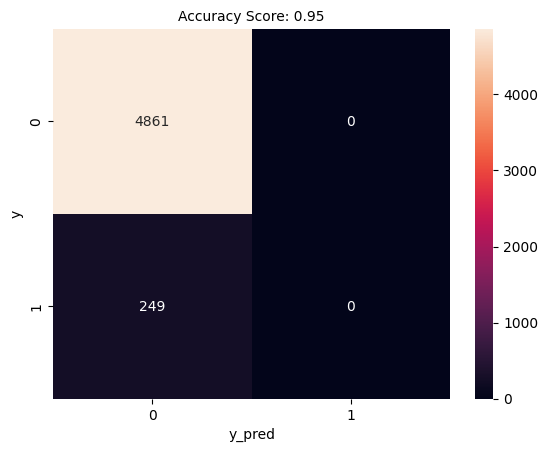

In [27]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show(block=True)

plot_confusion_matrix(y, y_pred)

In [28]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      4861
           1       0.00      0.00      0.00       249

    accuracy                           0.95      5110
   macro avg       0.48      0.50      0.49      5110
weighted avg       0.90      0.95      0.93      5110



In [29]:
y_prob = log_model.predict_proba(X)[:, 1]
roc_auc_score(y, y_prob)

0.8212388744444968

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20, random_state=42)

In [31]:
smote_over_sampling = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote_over_sampling.fit_resample(X_train, y_train)

In [32]:
log_model = LogisticRegression().fit(x_train_resampled, y_train_resampled)

y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.74      0.84       960
           1       0.14      0.66      0.23        62

    accuracy                           0.73      1022
   macro avg       0.56      0.70      0.54      1022
weighted avg       0.92      0.73      0.80      1022



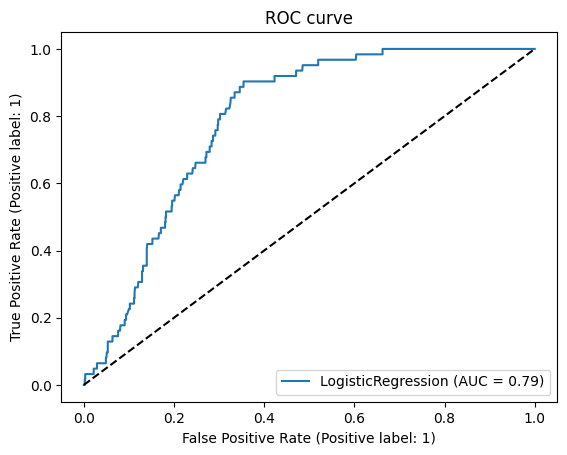

0.7902805779569892

In [33]:
from sklearn.metrics import RocCurveDisplay , accuracy_score, roc_auc_score, confusion_matrix, classification_report

roc_curve_display = RocCurveDisplay.from_estimator(log_model,X_test,y_test)

plt.title('ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.show()
roc_auc_score(y_test, y_prob)

In [34]:
import numpy as np
from sklearn.metrics import mean_squared_error, cohen_kappa_score, matthews_corrcoef, f1_score

def mse(y_true, y_pred):
 
  return mean_squared_error(y_true, y_pred)

def kappa(y_true, y_pred):

  return cohen_kappa_score(y_true, y_pred)

def mcc(y_true, y_pred):
  

  return matthews_corrcoef(y_true, y_pred)

def g_mean(y_true, y_pred):

  tpr = np.mean(y_pred * y_true)
  tnr = np.mean((1 - y_pred) * (1 - y_true))
  return np.sqrt(tpr * tnr)

mse = mse(y_test, y_pred)
kappa = kappa(y_test, y_pred)
mcc = mcc(y_test, y_pred)
g_mean = g_mean(y_test, y_pred)

print("MSE:", mse)
print("Kappa:", kappa)
print("MCC:", mcc)
print("G-mean:", g_mean)

MSE: 0.2651663405088063
Kappa: 0.14697457820267223
MCC: 0.21204781176117204
G-mean: 0.16694376623655047


In [35]:
from sklearn.model_selection import train_test_split, cross_validate
log_model = LogisticRegression().fit(x_train_resampled, y_train_resampled)

cv_results = cross_validate(log_model,
                            x_train_resampled, y_train_resampled,
                            cv=10,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

In [36]:
print("test_accuracy: ", cv_results['test_accuracy'].mean())
print("test_f1: ", cv_results['test_f1'].mean())
print("test_roc_auc: ", cv_results['test_roc_auc'].mean())

test_accuracy:  0.7654478150957025
test_f1:  0.7735917083351921
test_roc_auc:  0.8435473347558731


Accuracy: 0.8241645244215938
F1 score: 0.8310276679841898
Recall: 0.8670103092783505
Precision: 0.7979127134724858
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       975
           1       0.80      0.87      0.83       970

    accuracy                           0.82      1945
   macro avg       0.83      0.82      0.82      1945
weighted avg       0.83      0.82      0.82      1945

ROC AUC: 0.824274385408406


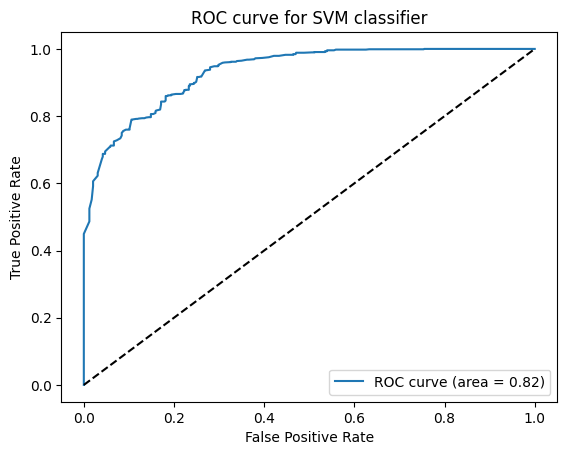

In [37]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from matplotlib.pyplot import plot, show

X_train,X_test, y_train,y_test=train_test_split(x_smote,y_smote,test_size=0.2,random_state=42)


clf = AdaBoostClassifier()


clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)


print('Accuracy:', accuracy)
print('F1 score:', f1_score)
print('Recall:', recall)
print('Precision:', precision)
print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc)


from sklearn.metrics import RocCurveDisplay , accuracy_score, roc_auc_score, confusion_matrix, classification_report

#roc_curve_display = RocCurveDisplay.from_estimator(log_model,X_test,y_test)

#plt.title('ROC curve')
#plt.plot([0, 1], [0, 1], 'k--')
#plt.show()
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for SVM classifier')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')
plt.show()

Accuracy: 0.9434447300771208
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       975
           1       0.93      0.95      0.94       970

    accuracy                           0.94      1945
   macro avg       0.94      0.94      0.94      1945
weighted avg       0.94      0.94      0.94      1945

ROC AUC: 0.943470790378007


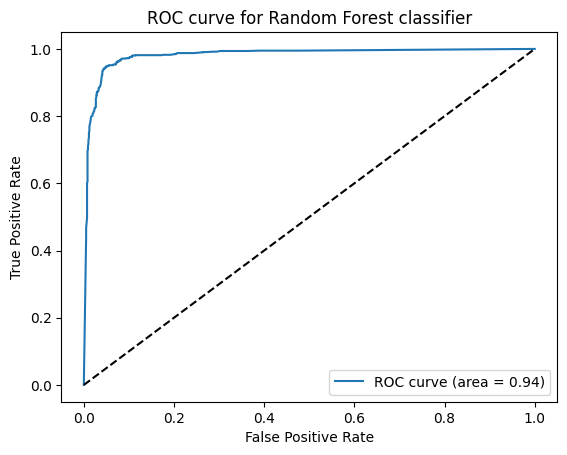

MSE: 0.056555269922879174
Kappa: 0.8868946923239586
MCC: 0.8870822869646813
G-mean: 0.47170660438917755
Accuracy: 0.9434447300771208
F1 score: <function f1_score at 0x0000025C3E7E8040>
Recall: 0.9536082474226805
Precision: 0.9343434343434344


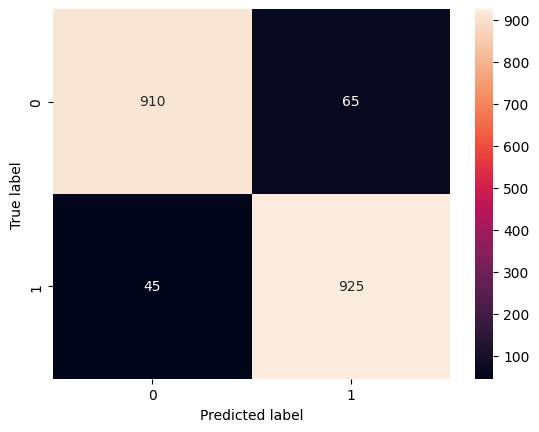

In [38]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from matplotlib.pyplot import plot, show

X_train,X_test, y_train,y_test=train_test_split(x_smote,y_smote,test_size=0.2,random_state=42)


clf = RandomForestClassifier()


clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)


print('Accuracy:', accuracy)

print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc)


from sklearn.metrics import RocCurveDisplay , accuracy_score, roc_auc_score, confusion_matrix, classification_report


plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Random Forest classifier')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')
plt.show()
confusion_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(confusion_matrix, annot=True, fmt=".0f")


plt.xlabel('Predicted label')
plt.ylabel('True label')

from sklearn.metrics import mean_squared_error, cohen_kappa_score, matthews_corrcoef, f1_score

def mse(y_true, y_pred):
 
  return mean_squared_error(y_true, y_pred)

def kappa(y_true, y_pred):

  return cohen_kappa_score(y_true, y_pred)

def mcc(y_true, y_pred):
  

  return matthews_corrcoef(y_true, y_pred)

def g_mean(y_true, y_pred):

  tpr = np.mean(y_pred * y_true)
  tnr = np.mean((1 - y_pred) * (1 - y_true))
  return np.sqrt(tpr * tnr)

mse = mse(y_test, y_pred)
kappa = kappa(y_test, y_pred)
mcc = mcc(y_test, y_pred)
g_mean = g_mean(y_test, y_pred)

print("MSE:", mse)
print("Kappa:", kappa)
print("MCC:", mcc)
print("G-mean:", g_mean)
print('Accuracy:', accuracy)
print('F1 score:', f1_score)
print('Recall:', recall)
print('Precision:', precision)

Accuracy: 0.9470437017994858
F1 score: 0.9474757776644569
Recall: 0.9577319587628866
Precision: 0.9374369323915237
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       975
           1       0.94      0.96      0.95       970

    accuracy                           0.95      1945
   macro avg       0.95      0.95      0.95      1945
weighted avg       0.95      0.95      0.95      1945

ROC AUC: 0.9470711075865716


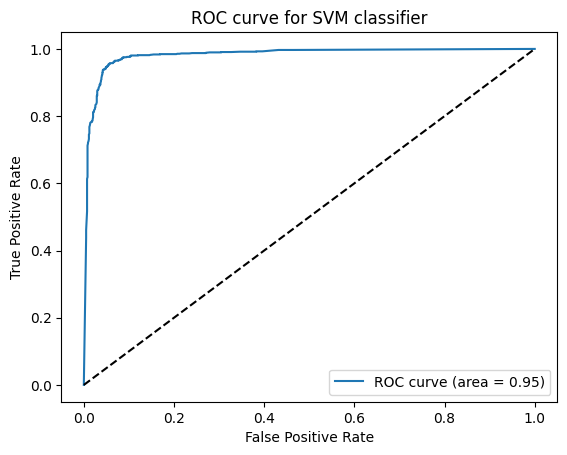

In [39]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from matplotlib.pyplot import plot, show

X_train,X_test, y_train,y_test=train_test_split(x_smote,y_smote,test_size=0.2,random_state=42)


clf = RandomForestClassifier()


clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)


print('Accuracy:', accuracy)
print('F1 score:', f1_score)
print('Recall:', recall)
print('Precision:', precision)
print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc)


from sklearn.metrics import RocCurveDisplay , accuracy_score, roc_auc_score, confusion_matrix, classification_report

#roc_curve_display = RocCurveDisplay.from_estimator(log_model,X_test,y_test)

#plt.title('ROC curve')
#plt.plot([0, 1], [0, 1], 'k--')
#plt.show()
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for SVM classifier')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')
plt.show()

Accuracy: 0.7403598971722365
F1 score: 0.7770419426048566
Recall: 0.9072164948453608
Precision: 0.6795366795366795
              precision    recall  f1-score   support

           0       0.86      0.57      0.69       975
           1       0.68      0.91      0.78       970

    accuracy                           0.74      1945
   macro avg       0.77      0.74      0.73      1945
weighted avg       0.77      0.74      0.73      1945

ROC AUC: 0.7407877346021675


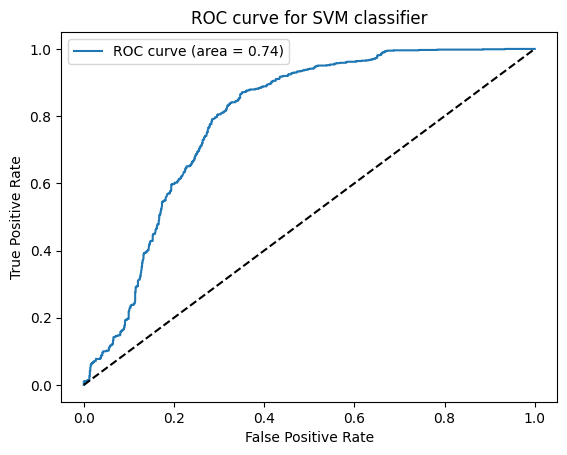

In [40]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from matplotlib.pyplot import plot, show

X_train,X_test, y_train,y_test=train_test_split(x_smote,y_smote,test_size=0.2,random_state=42)


clf = GaussianNB()


clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)


print('Accuracy:', accuracy)
print('F1 score:', f1_score)
print('Recall:', recall)
print('Precision:', precision)
print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc)


from sklearn.metrics import RocCurveDisplay , accuracy_score, roc_auc_score, confusion_matrix, classification_report

#roc_curve_display = RocCurveDisplay.from_estimator(log_model,X_test,y_test)

#plt.title('ROC curve')
#plt.plot([0, 1], [0, 1], 'k--')
#plt.show()
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for SVM classifier')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')
plt.show()

In [41]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from matplotlib.pyplot import plot, show

X_train,X_test, y_train,y_test=train_test_split(x_smote,y_smote,test_size=0.2,random_state=42)


clf = SVC(kernel='rbf', C=9.0, gamma=0.9)


clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)


print('Accuracy:', accuracy)
print('F1 score:', f1_score)
print('Recall:', recall)
print('Precision:', precision)
print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc)


from sklearn.metrics import RocCurveDisplay , accuracy_score, roc_auc_score, confusion_matrix, classification_report

#roc_curve_display = RocCurveDisplay.from_estimator(log_model,X_test,y_test)

#plt.title('ROC curve')
#plt.plot([0, 1], [0, 1], 'k--')
#plt.show()
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for SVM classifier')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')
plt.show()

Accuracy: 0.9249357326478149
F1 score: 0.927363184079602
Recall: 0.9608247422680413
Precision: 0.8961538461538462
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       975
           1       0.90      0.96      0.93       970

    accuracy                           0.92      1945
   macro avg       0.93      0.93      0.92      1945
weighted avg       0.93      0.92      0.92      1945

ROC AUC: 0.9250277557494053


AttributeError: predict_proba is not available when probability=False

<Figure size 640x480 with 0 Axes>

Learning rate set to 0.024735
0:	learn: 0.6740765	total: 148ms	remaining: 2m 27s
1:	learn: 0.6514166	total: 153ms	remaining: 1m 16s
2:	learn: 0.6338371	total: 157ms	remaining: 52.2s
3:	learn: 0.6189853	total: 160ms	remaining: 40s
4:	learn: 0.6010062	total: 165ms	remaining: 32.8s
5:	learn: 0.5869420	total: 169ms	remaining: 28s
6:	learn: 0.5721933	total: 173ms	remaining: 24.6s
7:	learn: 0.5616217	total: 177ms	remaining: 22s
8:	learn: 0.5498040	total: 181ms	remaining: 20s
9:	learn: 0.5385655	total: 185ms	remaining: 18.4s
10:	learn: 0.5275678	total: 191ms	remaining: 17.1s
11:	learn: 0.5177554	total: 196ms	remaining: 16.1s
12:	learn: 0.5099406	total: 200ms	remaining: 15.2s
13:	learn: 0.5011839	total: 205ms	remaining: 14.5s
14:	learn: 0.4947657	total: 210ms	remaining: 13.8s
15:	learn: 0.4864522	total: 215ms	remaining: 13.2s
16:	learn: 0.4794585	total: 219ms	remaining: 12.7s
17:	learn: 0.4722435	total: 224ms	remaining: 12.2s
18:	learn: 0.4674087	total: 229ms	remaining: 11.8s
19:	learn: 0.4598

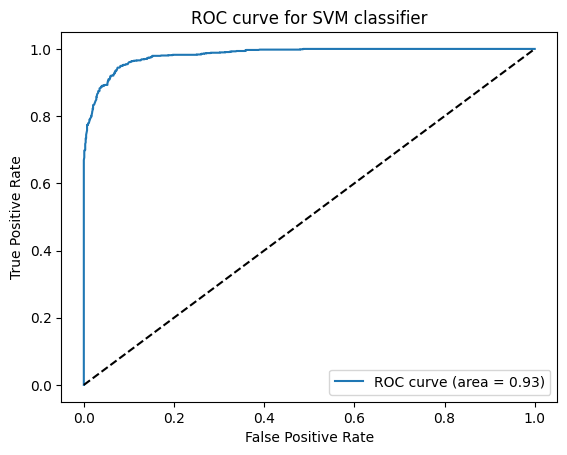

In [42]:
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from matplotlib.pyplot import plot, show

X_train,X_test, y_train,y_test=train_test_split(x_smote,y_smote,test_size=0.2,random_state=42)


clf = CatBoostClassifier ()


clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)


print('Accuracy:', accuracy)
print('F1 score:', f1_score)
print('Recall:', recall)
print('Precision:', precision)
print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc)


from sklearn.metrics import RocCurveDisplay , accuracy_score, roc_auc_score, confusion_matrix, classification_report

#roc_curve_display = RocCurveDisplay.from_estimator(log_model,X_test,y_test)

#plt.title('ROC curve')
#plt.plot([0, 1], [0, 1], 'k--')
#plt.show()
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for SVM classifier')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')
plt.show()

In [43]:
----------------------------------cbb------

SyntaxError: invalid syntax (2433870246.py, line 1)

Learning rate set to 0.024735
0:	learn: 0.6740765	total: 5.36ms	remaining: 5.35s
1:	learn: 0.6514166	total: 10.6ms	remaining: 5.3s
2:	learn: 0.6338371	total: 15.8ms	remaining: 5.24s
3:	learn: 0.6189853	total: 19.9ms	remaining: 4.95s
4:	learn: 0.6010062	total: 24.8ms	remaining: 4.94s
5:	learn: 0.5869420	total: 30.3ms	remaining: 5.01s
6:	learn: 0.5721933	total: 35.8ms	remaining: 5.08s
7:	learn: 0.5616217	total: 40.7ms	remaining: 5.05s
8:	learn: 0.5498040	total: 45.8ms	remaining: 5.04s
9:	learn: 0.5385655	total: 50.5ms	remaining: 5s
10:	learn: 0.5275678	total: 55.8ms	remaining: 5.02s
11:	learn: 0.5177554	total: 61ms	remaining: 5.02s
12:	learn: 0.5099406	total: 66.1ms	remaining: 5.02s
13:	learn: 0.5011839	total: 71.1ms	remaining: 5.01s
14:	learn: 0.4947657	total: 76.1ms	remaining: 5s
15:	learn: 0.4864522	total: 81.7ms	remaining: 5.02s
16:	learn: 0.4794585	total: 86.5ms	remaining: 5s
17:	learn: 0.4722435	total: 91.1ms	remaining: 4.97s
18:	learn: 0.4674087	total: 96ms	remaining: 4.95s
19:	le

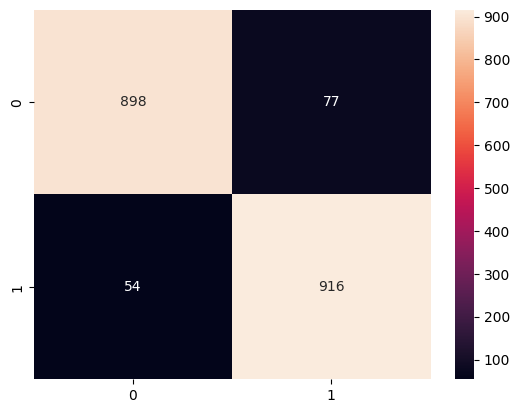

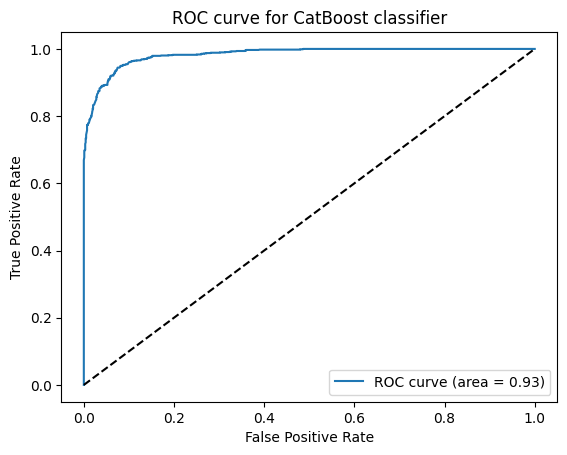

In [45]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score,cohen_kappa_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.2, random_state=42)

model = CatBoostClassifier ()
model.fit (X_train, y_train)
y_pred = model.predict (X_test)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt=".0f")
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
g_mean = (sensitivity * specificity)**0.5
accuracy = round(accuracy_score(y_test, y_pred), 3)
f1 = f1_score(y_test, y_pred)
print("Acuuracy:",accuracy)
print("Classification Report:\n", report)
print("AUC Score:", auc_score)
print("MSE:", mse)
print("G-mean:", g_mean)
print("Kappa:", kappa)
print("MCC:", mcc)
print('F1 score:', f1)
print('Recall:', recall)
print('Precision:', precision)
print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc)

plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for CatBoost classifier')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')
plt.show()

In [ ]:
-------------------

Acuuracy: 0.894
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89       975
           1       0.88      0.91      0.90       970

    accuracy                           0.89      1945
   macro avg       0.89      0.89      0.89      1945
weighted avg       0.89      0.89      0.89      1945

AUC Score: 0.8941395717684376
MSE: 0.10591259640102828
G-mean: 0.8939092521007246
Kappa: 0.7881958027171327
MCC: 0.7888632395209847
Accuracy: 0.894
F1 score: 0.895959595959596
Recall: 0.9144329896907216
Precision: 0.8782178217821782
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       975
           1       0.88      0.91      0.90       970

    accuracy                           0.89      1945
   macro avg       0.89      0.89      0.89      1945
weighted avg       0.89      0.89      0.89      1945

ROC AUC: 0.9326777689664287


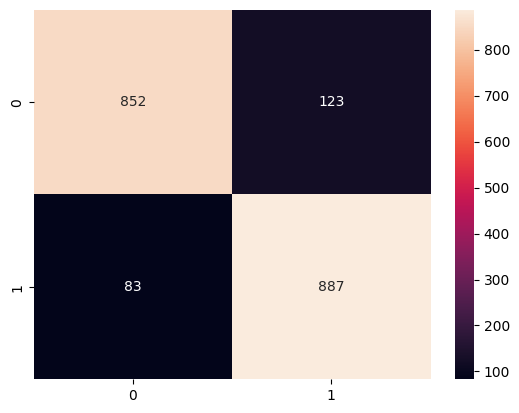

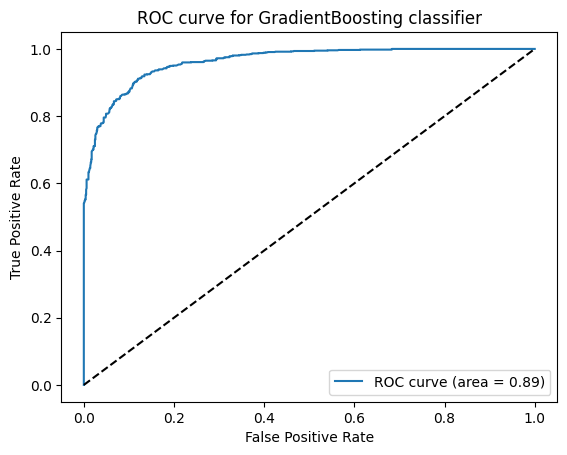

In [51]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef, mean_squared_error, roc_auc_score, confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.2, random_state=42)

model = GradientBoostingClassifier ()
model.fit (X_train, y_train)
y_pred = model.predict (X_test)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
g_mean = (sensitivity * specificity)**0.5
accuracy = round(accuracy_score(y_test, y_pred), 3)
print("Acuuracy:",accuracy)
precision = precision_score(y_test, y_pred)
recall= recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt=".0f")
print("Classification Report:\n", report)
print("AUC Score:", auc_score)
print("MSE:", mse)
print("G-mean:", g_mean)
print("Kappa:", kappa)
print("MCC:", mcc)
print('Accuracy:', accuracy)
print('F1 score:', f1)
print('Recall:', recall)
print('Precision:', precision)
print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc)
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for GradientBoosting classifier')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')
plt.show()

In [ ]:
--------------------knn-

Acuuracy: 0.867
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.79      0.86       975
           1       0.82      0.94      0.88       970

    accuracy                           0.87      1945
   macro avg       0.87      0.87      0.87      1945
weighted avg       0.87      0.87      0.87      1945

AUC Score: 0.8670261697065821
MSE: 0.13316195372750642
G-mean: 0.8639323261892301
Kappa: 0.7337749674323478
MCC: 0.7418326720531205
Accuracy: 0.867
F1 score: 0.8756601056168988
Recall: 0.9402061855670103
Precision: 0.8194070080862533
              precision    recall  f1-score   support

           0       0.93      0.79      0.86       975
           1       0.82      0.94      0.88       970

    accuracy                           0.87      1945
   macro avg       0.87      0.87      0.87      1945
weighted avg       0.87      0.87      0.87      1945

ROC AUC: 0.9326777689664287


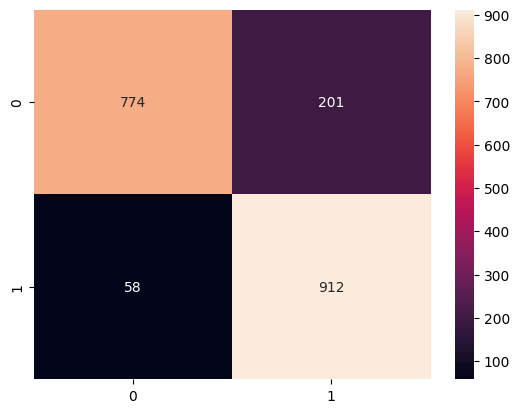

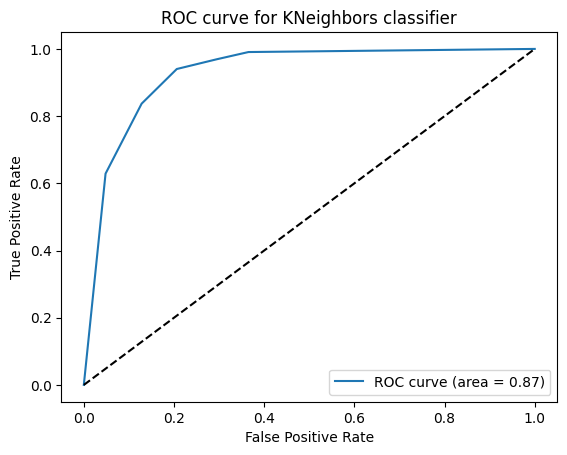

In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef, mean_squared_error, roc_auc_score, confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.2, random_state=42)

model = KNeighborsClassifier ()
model.fit (X_train, y_train)
y_pred = model.predict (X_test)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
g_mean = (sensitivity * specificity)**0.5
accuracy = round(accuracy_score(y_test, y_pred), 3)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall= recall_score(y_test, y_pred)
print("Acuuracy:",accuracy)

sns.heatmap(conf_matrix, annot=True, fmt=".0f")
print("Classification Report:\n", report)
print("AUC Score:", auc_score)
print("MSE:", mse)
print("G-mean:", g_mean)
print("Kappa:", kappa)
print("MCC:", mcc)
print('Accuracy:', accuracy)
print('F1 score:', f1)
print('Recall:', recall)
print('Precision:', precision)
print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc)
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for KNeighbors classifier')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')
plt.show()

Acuuracy: 0.93
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.79      0.86       975
           1       0.82      0.94      0.88       970

    accuracy                           0.87      1945
   macro avg       0.87      0.87      0.87      1945
weighted avg       0.87      0.87      0.87      1945

AUC Score: 0.9300978059740946
MSE: 0.0699228791773779
G-mean: 0.9300629990116713
Kappa: 0.8601592319648125
Accuracy: 0.93
F1 score: 0.9304703476482618
Recall: 0.9381443298969072
Precision: 0.922920892494929
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       975
           1       0.92      0.94      0.93       970

    accuracy                           0.93      1945
   macro avg       0.93      0.93      0.93      1945
weighted avg       0.93      0.93      0.93      1945

ROC AUC: 0.9326777689664287


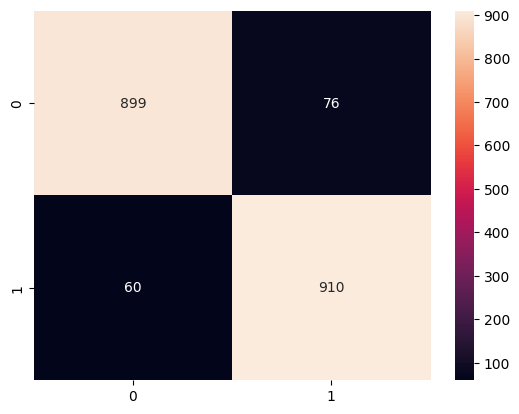

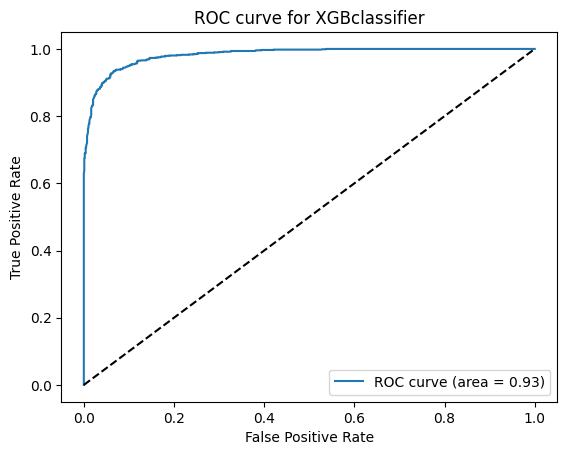

In [53]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, cohen_kappa_score, matthews_corrcoef, mean_squared_error, roc_curve, roc_auc_score, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.2,random_state=42)

clf = XGBClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
g_mean = (sensitivity * specificity)**0.5
accuracy = round(accuracy_score(y_test, y_pred), 3)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall= recall_score(y_test, y_pred)
print("Acuuracy:",accuracy)

sns.heatmap(conf_matrix, annot=True, fmt=".0f")
print("Classification Report:\n", report)
print("AUC Score:", auc_score)
print("MSE:", mse)
print("G-mean:", g_mean)
print("Kappa:", kappa)
print('Accuracy:', accuracy)
print('F1 score:', f1)
print('Recall:', recall)
print('Precision:', precision)
print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc)
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for XGBclassifier')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')
plt.show()

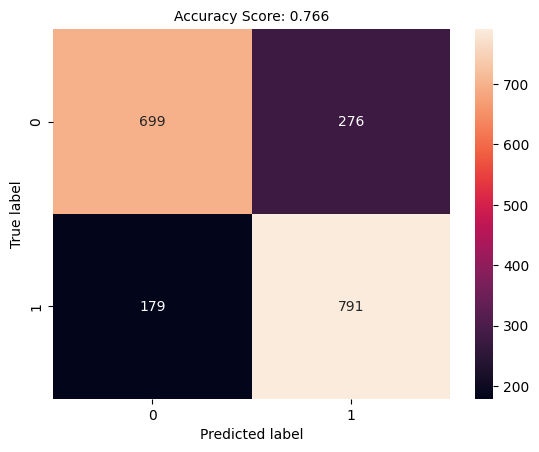

Accuracy: 0.7660668380462725
              precision    recall  f1-score   support

           0       0.80      0.72      0.75       975
           1       0.74      0.82      0.78       970

    accuracy                           0.77      1945
   macro avg       0.77      0.77      0.77      1945
weighted avg       0.77      0.77      0.77      1945

MSE: 0.23393316195372751
ROC AUC: 0.7661934972244251
precision 0.7413308341143393
f1scon 0.7766323024054983
recall 0.8154639175257732
Kappa: 0.5322505199565536
MCC: 0.5349166855600987
G-mean: 0.7775143382404779


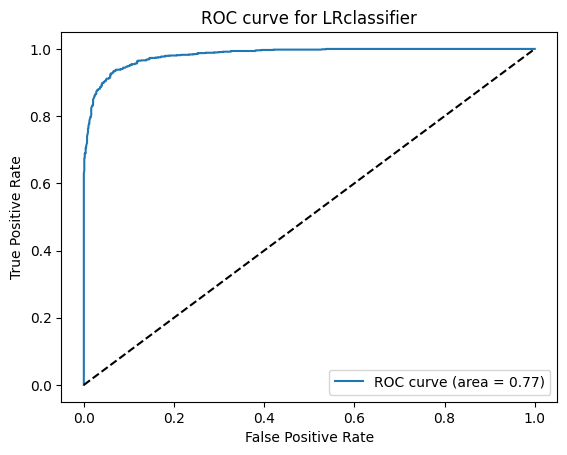

In [54]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc


X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1= f1_score(y_test, y_pred)
mse = np.mean((y_test - y_pred)**2)
confusion_matrix = confusion_matrix(y_test, y_pred)
acc = round(accuracy_score(y_test, y_pred), 3)
sns.heatmap(confusion_matrix, annot=True, fmt=".0f")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Accuracy Score: {0}'.format(acc), size=10)
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = auc(fpr, tpr)

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

g_mean = np.sqrt(precision * recall)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall= recall_score(y_test, y_pred)
print('Accuracy:', accuracy)
print(classification_report(y_test, y_pred))
print('MSE:', mse)
print('ROC AUC:', auc)
print('precision',precision)
print('f1scon',f1)
print('recall',recall)
print('Kappa:', kappa)
print('MCC:', mcc)
print('G-mean:', g_mean)
plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for LRclassifier')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')
plt.show()